In [1]:
# Load the data
from datasets import load_dataset
import seaborn as sns
from better_profanity import profanity

dataset = load_dataset("reddit_tifu", 'long')
dataset

Found cached dataset reddit_tifu (/Users/shubi/.cache/huggingface/datasets/reddit_tifu/long/1.1.0/1c73fb08807b54ec26b025829b2a3d90c6f7466dac20801c825571af9514c049)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['ups', 'num_comments', 'upvote_ratio', 'score', 'documents', 'tldr', 'title'],
        num_rows: 42139
    })
})

In [2]:

import pandas as pd
raw_df = pd.DataFrame(dataset['train'])
raw_df

,ups,num_comments,upvote_ratio,score,documents,tldr,title
0,115.0,23.0,0.88,115.0,this actually happened a couple of years ago. ...,confuse a 5th grade girl for a boy in front of...,gender-stereotyping
1,16.0,12.0,0.79,16.0,"it was last october, but i'm feeling the fall-...","i found my estranged dad, thought i loved him ...",telling my dad that i love him.
2,55.0,10.0,0.85,55.0,so i had the brilliant idea to use veet hair r...,had my balls burned by sauron and was left dev...,i was deveeted...
3,90.0,20.0,0.92,90.0,today i was going to have a bath after a long ...,peppermint + bath = burning cold ladybits.,wanting a pepperminty bath.
4,81.0,18.0,0.79,81.0,"i haven't had a bath in practically years so, ...","got too high and too hot in the bath, almost c...",having a spliff in the bath.
...,...,...,...,...,...,...,...
42134,105.0,18.0,0.94,105.0,this happened back in middle school.\n\nmy fam...,forgot my quarter for lunch at school for a we...,forgetting my quarter for lunch
42135,96.0,64.0,0.92,96.0,my girlfriend told me she has no hair beneath ...,girlfriend prefers clean shaven groin. i try t...,trying to shave my pubes for the first time
42136,726.0,110.0,0.91,726.0,today at work i accidentally crashed a row of ...,today i broke a window that costs more then i ...,breaking a $900 window with a shopping cart.
42137,26.0,5.0,0.77,26.0,so as u can tell from the title it didn't happ...,i invited over new girlfriend for dinner to sp...,slicing open my finger on first valentines wit...


In [23]:
df = raw_df.copy()
# discard punctuation
for col in ['tldr', 'documents']:
    df[col+'_text'] = df[col].str.replace('[^\w\s]','', regex=True) # remove punctuation
    df[col + '_num_words'] = df[col+'_text'].str.split().str.len() # count words
    df[col + '_sentences'] = df[col].str.split('.') # split into sentences
    # drop empty sentences
    df[col + '_sentences'] = df[col + '_sentences'].apply(lambda x: [s for s in x if len(s) > 0])
    df[col + '_num_sentences'] = df[col + '_sentences'].str.len() # count sentences
#discard stories with tldr longer than 100 words
df = df[df['tldr_num_words'] <= 60]
df = df[df['documents_num_words'].between(100,400)]




In [24]:
df.describe()

,ups,num_comments,upvote_ratio,score,tldr_num_words,tldr_num_sentences,documents_num_words,documents_num_sentences
count,25967.000000,25967.000000,25967.000000,25967.000000,25967.00000,25967.000000,25967.000000,25967.000000
mean,228.477529,31.802596,0.781987,228.477529,18.03077,1.364039,246.839142,14.568452
std,1503.574648,121.655461,0.164705,1503.574648,9.30343,0.755165,80.076508,6.342894
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,100.000000,1.000000
25%,3.000000,3.000000,0.690000,3.000000,11.00000,1.000000,181.000000,10.000000
50%,10.000000,7.000000,0.820000,10.000000,17.00000,1.000000,243.000000,14.000000
75%,44.000000,18.000000,0.900000,44.000000,23.00000,1.000000,311.000000,18.000000
max,85249.000000,2715.000000,1.000000,85249.000000,60.00000,14.000000,400.000000,232.000000


In [25]:
melted = df[['tldr_num_words', 'documents_num_words']].melt()

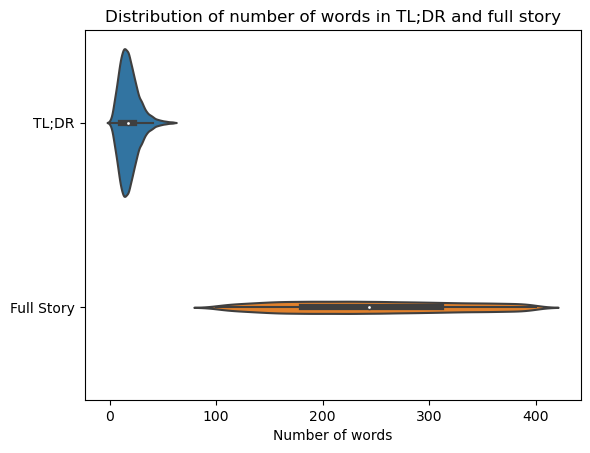

In [26]:
#violin plot
sns.violinplot(data=melted, x='value', y='variable')
import matplotlib.pyplot as plt
plt.xlabel('Number of words')
plt.title('Distribution of number of words in TL;DR and full story')
plt.yticks([0,1], ['TL;DR', 'Full Story'])
plt.ylabel('')
plt.show()

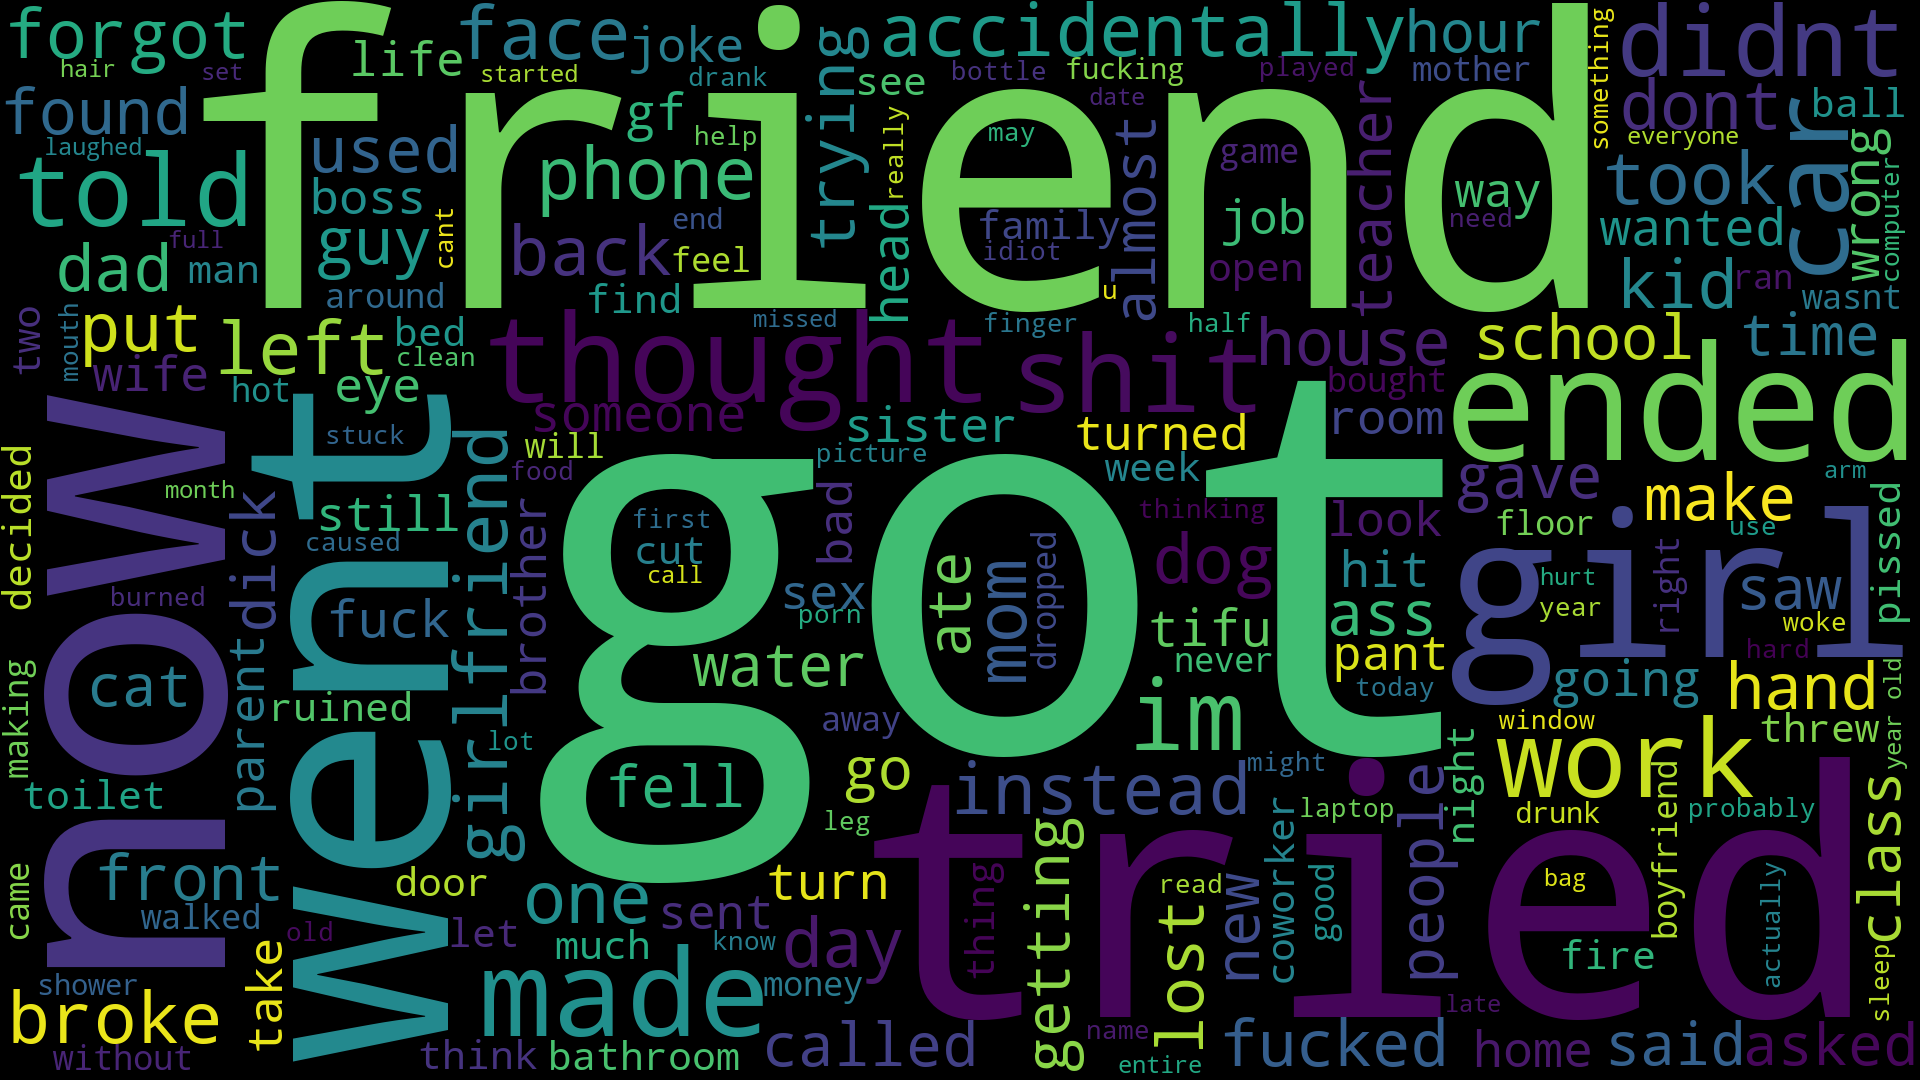

In [28]:
from wordcloud import WordCloud
WordCloud(width=1920, height=1080).generate(' '.join(df['tldr_text'])).to_image()

# Censoring

In [ ]:
from tqdm import tqdm
tqdm.pandas()
df['censored'] = df['documents'].progress_apply(profanity.censor)

# Filtration

In [ ]:
pd.set_option('display.max_colwidth', 1000)


In [32]:
topics = ['relationship', 'work', 'family']
sub_dfs = []
for topic in topics:
    sub_df = df[df['documents'].str.contains(topic)].sample(150, random_state=7).copy()
    sub_df['topic'] = topic
    sub_dfs.append(sub_df)
    
final_df = pd.concat(sub_dfs)


In [34]:
final_df['censored'] = final_df['documents'].progress_apply(profanity.censor)

100%|██████████| 450/450 [02:08<00:00,  3.51it/s]


In [37]:
final_df.reset_index(inplace=True)

In [ ]:
final_df.rename(columns={'index': 'original_id'}, inplace=True)

In [40]:
# randomly assign 'exploration/evaluation/part3' label to each story, 20% exploration, 20% evaluation, 60% part3
import numpy as np
labels = np.random.choice(['exploration', 'evaluation', 'part3'], size=len(final_df), p=[0.2, 0.2, 0.6])
final_df['batch'] = labels


In [ ]:
final_df = final_df[['batch', 'topic', 'documents', 'censored', 'tldr','title', 'ups','num_comments','upvote_ratio','score']].copy()
assert final_df.duplicated().sum() == 0, 'There are duplicates in the final dataset'

In [ ]:
final_df = final_df.melt(id_vars=['batch', 'topic', 'censored','title', 'ups','num_comments','upvote_ratio','score'],
              value_vars=['tldr', 'documents'], value_name='text', var_name='type')

In [41]:
final_df.to_csv('DIFU.csv')